# Finding Similar Items

## 1.	Introduction


### Mining information from Text Data 

-	This project will explore and analyze the information stored in a particular dataset. In this case the ACL Anthology dataset (https://aclanthology.org/). We will explore different techniques for obtaining valuable information.

Randomly select 1000 abstracts from the whole dataset. Find the similar items using pairwise Jaccard similarities, MinHash and LSH (vectorized versions) .

   1. Compare the performance in time and the results for *k*-shingles = 3, 5 and 10, for the three methods and similarity thresholds *s*=0.1 and 0.2. Use 50 hashing functions. Comment your results. 
      
   2. Compare the results obtained for MinHash and LSH for different similarity thresholds *s* = 0.1, 0.2, 0.25 and 50, 100 and 200 hashing functions. Comment your results.
   
   3. For MinHashing using 100 hashing functions and *s* = 0.1 and 0.2,  find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each *s*. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?
 

-	Define all and only used package imports below

In [136]:
import requests # to download the dataset
import gzip
import shutil # to extract the gz file
import re # for text cleaning

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 

from nltk.corpus import stopwords # calculation of stopwords
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alext\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.	ELT

### Extract, Load and Transform of data.



- In your code data should be retrieved from an online source, NOT from your local drive, otherwise, nobody can run your code without additional effort.

In [2]:
# Download data 
url = 'https://aclanthology.org/anthology+abstracts.bib.gz'
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

# Extract the gz file
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [25]:
# Find all the rows in the file that contain an abstract and laod the text to a list
abstracts = []
with open("anthology+abstracts.bib", "r",encoding="UTF-8") as f:
    s = f.readlines()
    for x in s:
        if x.__contains__('abstract'):
            start = x.find('   abstract = "') + len('   abstract = "')
            end = x.find('",')
            substring = x[start:end]
            abstracts.append(substring)
    f.close()

print("{} abstracts were found in the file.".format(len(abstracts)))

30747 abstracts were found in the file.


In [93]:
# Some cleaning

minletters = 200 
abstracts_clean = []

for a in abstracts: 
    if len(a) > minletters and len(re.findall('[a-zA-Z]',a)) >0.5*len(a):
        abstracts_clean.append(a) 
print("After cleaning, {} abstracts were remaining.".format(len(abstracts_clean)))

After cleaning, 30244 abstracts were remaining.


In [127]:
# Randomly select 1000 abstracts
random.seed(10)
abstracts_1000 = random.sample(abstracts_clean,1000)


### Report the essential description of data.
-	Don’t print out dozens of raw lines.

In [128]:
data = pd.DataFrame(abstracts_1000, columns=['abstracts'])
# Number of words
data['word_count'] = data['abstracts'].apply(lambda x: len(str(x).split(" ")))
data[['abstracts','word_count']]

#Number of characters
data['char_count'] = data['abstracts'].str.len() ## this also includes spaces
data[['abstracts','char_count']]

# Average word length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['abstracts'].apply(lambda x: avg_word(x))

# Number of stop words 
stop = stopwords.words('english')
data['stopwords'] = data['abstracts'].apply(lambda x: len([x for x in x.split() if x in stop]))

# Number of Uppercase words
data['upper'] = data['abstracts'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

# Descriptive statistics of the DataFrame
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
word_count,1000.0,133.187000,43.394321,28.000000,103.000000,133.000000,161.000000,474.000000
char_count,1000.0,918.962000,296.701511,204.000000,719.750000,915.000000,1107.250000,3293.000000
avg_word,1000.0,5.929176,0.436629,4.795775,5.645028,5.886916,6.170461,7.882883
stopwords,1000.0,44.228000,18.795246,0.000000,33.000000,44.000000,56.000000,175.000000
upper,1000.0,2.344000,2.757039,0.000000,0.000000,1.000000,4.000000,15.000000


In [138]:
text = " ".join(abstracts for abstracts in data.abstracts.astype(str))
print ("There are {} words in the combination of all cells in column abstracts.".format(len(text)))
stopwords = set(STOPWORDS)

# to exclude certain words
stopwords.update(["a", "about", "above", "after", "again", "against", "all", 'also' "am", "an", "and", "any", "are",
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", 
             "by", 'can', "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", 
             "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", 
             "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", 
             "most", "my", "myself", 'no', 'not', "nor", "of", "on", "once", "only", "or", "other", "ought", "our", 
             "ours", "ourselves", "out", "over", "own", 's', "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", 
             "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", 
             "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", 
             "we'll", "we're", "we've", "were", 'will', "what", "what's", "when", "when's", "where", "where's", 
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", 
             "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "br", "one", "want", "come", 
             "gets","without", 'rather', "although", "will", "see", "even","make", "seem"])


There are 919961 words in the combination of all cells in column abstracts.


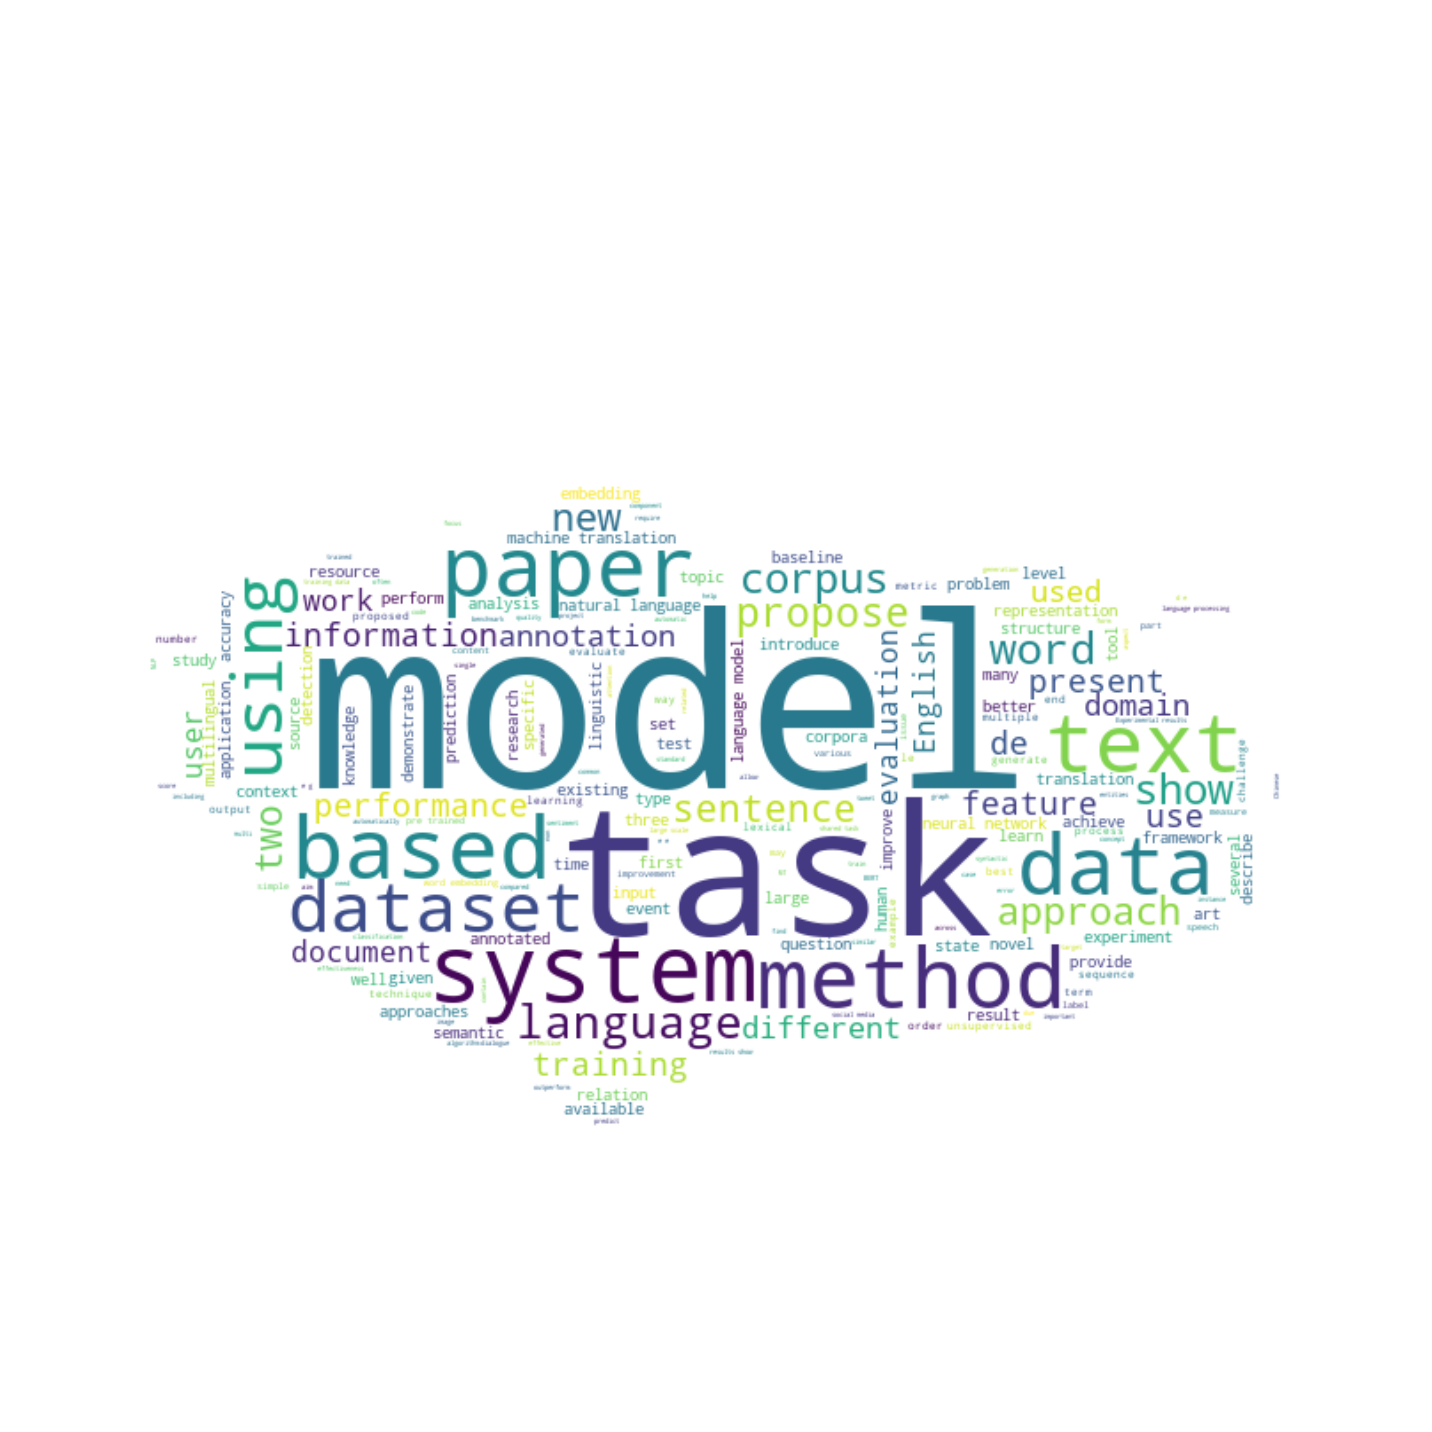

In [139]:
# Generate a word cloud image
from PIL import Image
from io import BytesIO
url = "https://thumbs.dreamstime.com/b/black-cloud-smoke-isolated-over-white-background-shape-illustration-102945454.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

mask = np.array(img)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=400, height=200, mask=mask).generate(text)

# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

## 3.	Modeling

### Prepare analytics here and construct all the data objects you will use in your report.
•	Write functions and classes to simplify tasks. Do not repeat yourself.

•	Avoid output.

•	Refactor your code until it’s clean

## 4.	Results

•	Print out relevant tables nicely, display well-annotated charts and explain if needed in plain English.
•	Use minimum code here, just output-functions’ calls.

## 5.	Conclusions

•	Summarize your findings here in 5...10 lines of text.

In [5]:
#! git clone https://github.com/AlexTouvras/FindingSimilarItems

Cloning into 'FindingSimilarItems'...


In [94]:
# ! git add Project 1
# ! git commit -am "data loaded and cleaned" 
# ! git push 

[main 9c4ee28] data loaded and cleaned

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
The file will have its original line endings in your working directory



 3 files changed, 158 insertions(+), 50 deletions(-)


To https://github.com/AlexTouvras/FindingSimilarItems
   de3eab6..9c4ee28  main -> main
